# An Introduction to SageMaker Random Cut Forests

***Unsupervised anomaly detection on timeseries data a Random Cut Forest algorithm.***

---

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Training](#Training)
1. [Inference](#Inference)
1. [Epilogue](#Epilogue)

# Introduction
***

This notebook is based on the AWS RCF sample notebook at https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/random_cut_forest

Amazon SageMaker Random Cut Forest (RCF) is an algorithm designed to detect anomalous data points within a dataset. Examples of when anomalies are important to detect include when website activity uncharactersitically spikes, when temperature data diverges from a periodic behavior, or when changes to public transit ridership reflect the occurrence of a special event.

In this notebook, we will use the SageMaker RCF algorithm to train an RCF model on the Numenta Anomaly Benchmark (NAB) NYC Taxi dataset which records the amount New York City taxi ridership over the course of six months. We will then use this model to predict anomalous events by emitting an "anomaly score" for each data point. The main goals of this notebook are,

* to learn how to obtain, transform, and store data for use in Amazon SageMaker;
* to create an AWS SageMaker training job on a data set to produce an RCF model,
* use the RCF model to perform inference with an Amazon SageMaker endpoint.

The following are ***not*** goals of this notebook:

* deeply understand the RCF model,
* understand how the Amazon SageMaker RCF algorithm works.

If you would like to know more please check out the [SageMaker RCF Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

# Setup

***

*This notebook was created and tested on an ml.m4.xlarge notebook instance.*

Our first step is to setup our AWS credentials so that AWS SageMaker can store and access training data and model artifacts. We also need some data to inspect and to train upon.

## Select Amazon S3 Bucket

We first need to specify the locations where we will store our training data and trained model artifacts. ***This is the only cell of this notebook that you will need to edit.*** In particular, we need the following data:

* `bucket` - An S3 bucket accessible by this account.
* `prefix` - The location in the bucket where this notebook's input and output data will be stored. (The default value is sufficient.)

In [1]:
import boto3
import botocore
import sagemaker
import sys
import pandas as pd
import io
import numpy as np
from datetime import datetime

bucket = 'sagemaker-davidrob'   # <--- specify a bucket you have access to
prefix = 'group-project/bitcoin'
execution_role = sagemaker.get_execution_role()


# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))
    
# create the s3 client
s3 = boto3.client('s3')

Training input/output will be stored in: s3://sagemaker-davidrob/group-project/bitcoin


## Obtain and Inspect Example Data


Our data is minute-level bitcoin pricing data. The initial subset covers one month. Other sets contain one year, four years, and six years' worth of data. The 6-year set starts in 2011 and goes through July 2018. In the first step, below, we pick which data set to use throughout the remainder of this notebook.

In [3]:
# Step 1:
# We have several datasets. Define them all upfront so we can switch between them easily. 
# To switch between datasets, change the uncommented line in the folllowing lines.
# For the most part, this step is the only place we need to change to switch datasets, 
# except for some of the charts where we select small date ranges.

month_initial = s3.get_object(Bucket=bucket, Key=f'{prefix}/bitcoinmonth.csv')
#year_initial = s3.get_object(Bucket=bucket, Key=f'{prefix}/bitflyerJPY_1-min_data_2017-07-04_to_2018-06-27.csv')
#fouryears_initial = s3.get_object(Bucket=bucket, Key=f'{prefix}/bitflyerJPY_1-min_data_2017-07-04_to_2018-06-27.csv')
#sixyears_initial = s3.get_object(Bucket=bucket, Key=f'{prefix}/bitflyerJPY_1-min_data_2017-07-04_to_2018-06-27.csv')

# Step 2: copy data object to a name that can be consistent through the rest of the script
raw_data = month_initial

# Step 3: convert the data to a workable format
df_all_columns = pd.read_csv(io.BytesIO(raw_data['Body'].read()), encoding="ISO-8859-1", low_memory=False)

In [4]:
# Step 4: quick reality check.
df_all_columns.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,datetime
0,1527638460,813324,813615,813076,813076,9.961829,8.100150e+06,813118.72628,2018-05-30 00:01:00
1,1527638520,813334,813334,813076,813076,0.421000,3.423099e+05,813087.64371,2018-05-30 00:02:00
2,1527638580,813135,813600,813128,813600,1.846366,1.502083e+06,813534.76321,2018-05-30 00:03:00
3,1527638640,813620,814476,813600,814476,2.059000,1.676414e+06,814188.19552,2018-05-30 00:04:00
4,1527638700,813625,814201,813300,813445,3.543264,2.882671e+06,813563.61022,2018-05-30 00:05:00


In [7]:
# Step 5: convert Unix time to datetime by adding a new field to the dataframe
df_all_columns['datetime'] = pd.to_datetime(df_all_columns.Timestamp, unit='s')

# step 6: subset to just have the two columns, and rename them.
# I think we need to have a column named literally "value"
df = df_all_columns[['datetime','Volume_(BTC)','Weighted_Price']]
df = df.rename(index=str, columns={"datetime": 'timestamp', 'Volume_(BTC)':'value', 'Weighted_Price':'price'})

# Step 7: another reality check. look at the row count and first few rows of the cleaned up dataframe
print("row count: " + str(len(df.index)))
df.head()

# the one-month dataset should have 40,320 records.
# one-year = about 511,000

row count: 40320


,timestamp,value,price
0,2018-05-30 00:01:00,9.961829,813118.72628
1,2018-05-30 00:02:00,0.421000,813087.64371
2,2018-05-30 00:03:00,1.846366,813534.76321
3,2018-05-30 00:04:00,2.059000,814188.19552
4,2018-05-30 00:05:00,3.543264,813563.61022


Human beings are visual creatures so let's take a look at a plot of the data.

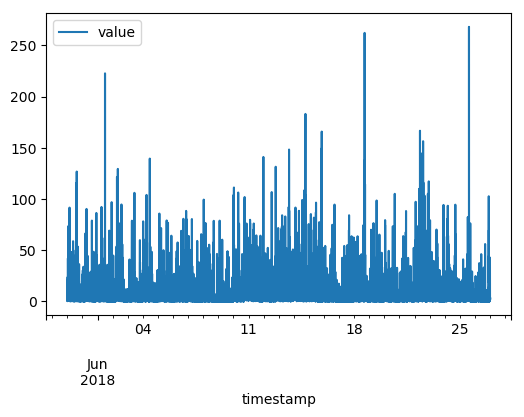

In [9]:
# Step 8: a simple graph of the entire dataset
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

df.plot(x='timestamp', y='value')

Let's zoom in on a random subset.

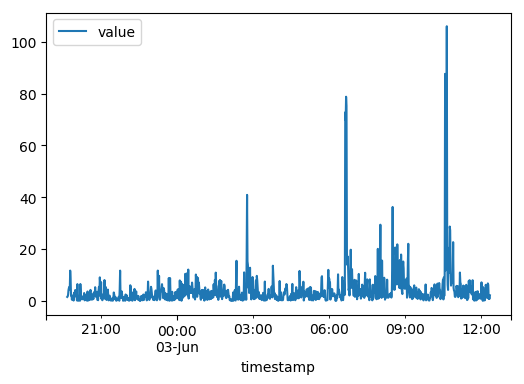

In [10]:
# step 9: a graph of a smaller date range within the dataset.
# the range to zoom in on will depend on the selected dataset (month, year, 4-year, 6-year)
subset1 = df[5500:6500]
subset1.plot(x='timestamp', y='value')

# Training

***

Next, we configure a SageMaker training job to train the Random Cut Forest (RCF) algorithm on the bitcoin data.

## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.m4`, `ml.c4`, or `ml.c5`
* Current limitations:
  * The RCF algorithm does not take advantage of GPU hardware.

In [11]:
# step 10: create the random cut forest object, defining two parameters: num_samples_per_tree and num_trees

from sagemaker import RandomCutForest

session = sagemaker.Session()

# I found fastest response times when using only a single EC2 instsance at this step. 
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.c5.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=2048,
                      num_trees=1000)
     
# automatically upload the training data to S3 and run the training job
# the ".reshape(-1,1) rearranges the data into a single column. not sure why.
# To get this to work, I needed to have fields literally named "value" and "timestamp" (see step 6 above)
rcf.fit(rcf.record_set(df.value.as_matrix().reshape(-1,1)))


INFO:sagemaker:Creating training-job with name: randomcutforest-2018-09-29-23-35-30-556


2018-09-29 23:35:30 Starting - Starting the training job...
Launching requested ML instances......
Preparing the instances for training...
2018-09-29 23:37:11 Downloading - Downloading input data
2018-09-29 23:37:19 Training - Downloading the training image...
2018-09-29 23:37:59 Uploading - Uploading generated training model
Docker entrypoint called with argument(s): train
[09/29/2018 23:37:55 INFO 140453860910912] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[09/29/2018 23:37:55 INFO 140453860910912] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_bat


2018-09-29 23:38:05 Completed - Training job completed
Billable seconds: 54


It takes a few minutes for the training instance to become available.

Don't worry about the output text above turning red. That's not an indication of an error.

You can view the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below.
https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/jobs

If you see the message 

> `Billable seconds: nn`

at the end of the output in the box above, that means training successfully completed and the output RCF model was stored in the specified output path.

Building the model with the one-month extract took about 5 minutes and 60 billable seconds.

In [12]:
# Step 11: another reality check, confirming the name of the new training job. Not very helpful, atcually.
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2018-09-29-23-35-30-556


# Inference

***

A trained Random Cut Forest model does nothing on its own. We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores from input time series data points.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the `ml.c5` instance type as it provides the fastest inference time at the lowest cost. 

Make sure to delete the endpoint(s) after you are done with the inference. They are expensive if they are left running!

In [13]:
# Step 12:  spin up endpoint instances for generating anamaly scores. 
# At this point, we're just starting the endpoint machines, which takes some time.
rcf_inference = rcf.deploy(
    initial_instance_count=2,
    instance_type='ml.c5.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2018-09-29-23-44-58-167
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-09-29-23-35-30-556


---------------------------------------------------------------!

Building the endpoint also takes some time. 5 or 10 minutes.

You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below.  (https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/endpoints)

Congratulations! You now have a functioning SageMaker RCF inference endpoint. 

In [14]:
# Step 13: another reality check. The name isn't important to know, but it's nice to know things are working so far.
print('Endpoint name: {}'.format(rcf_inference.endpoint))

Endpoint name: randomcutforest-2018-09-29-23-35-30-556


## Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

In [15]:
# Step 14: getting ready to send data to the endpoint so that it will spit out anomaly scores

from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.

In [16]:
# Step 15: Here we take the original data and reformat it according to the format we just specified in step 14. 
# And we peak at the first several values. We're only sending the 'value' data element for anomaly scoring. Is that right?
df_numpy = df.value.as_matrix().reshape(-1,1)
print(df_numpy[:10])

[[9.96182897]
 [0.421     ]
 [1.84636559]
 [2.05900025]
 [3.54326392]
 [1.0615    ]
 [4.77401023]
 [1.51016605]
 [0.297791  ]
 [4.43403334]]
40320


In [18]:
# Step 16: We generated anomaly scores for 10 records. let's look at them.
results = rcf_inference.predict(df_numpy[:10])
print(results['scores'])

[{'score': 1.3020006497}, {'score': 0.933102363}, {'score': 0.7951078655}, {'score': 0.7936339972}, {'score': 0.8205886379}, {'score': 0.8235570901}, {'score': 0.864489771}, {'score': 0.7927229948}, {'score': 0.9693388384}, {'score': 0.8470221605}]


## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the entire bitcoin dataset.

We can't get all the results at once - the dataset is too big: results = rcf_inference.predict(df_1yr2col_numpy) fails

So this section
- creates an object to hold the results, 
- breaks the dataset into blocks of 10,000, 
- retrieves anomaly scores for them, 
- and appends them to the results object.

At 10,000 records per loop, this loops over 500 times for the one-year dataset, and takes a while.

In [19]:
# Step 17: Generate anomaly scores for the entire dataset, 10,000  records at a time.
from collections import defaultdict
results = defaultdict(list)

# testing with a small subset to work out the logic of looping over even smaller subsets, e.g., 30 divided into subsets of 10
#sample = df_1yr2col_numpy[0:29]

# this function splits the dataset into n subsets
def get_every_n(a, n=2):
    for i in range((a.shape[0] // n) + 1):
        yield a[n*i:n*(i+1)]

#for subset in get_every_n(sample,10):    #testing with a small subset
for subset in get_every_n(df_numpy,10000):
    subset_results = rcf_inference.predict(subset)
    for score in subset_results['scores']:
        results['scores'].append(score)
    #print(results)  #this should show results growing by n items per iteration

# reality check - how many scores did we generate?
print(len(results['scores']))

40320


In [20]:
# Step 18: add scores to bitcoin data frame and print first few values

scores = [datum['score'] for datum in results['scores']]

df['score'] = pd.Series(scores, index=df.index)
df.head(10)

,timestamp,value,price,score
0,2018-05-30 00:01:00,9.961829,813118.72628,1.302001
1,2018-05-30 00:02:00,0.421000,813087.64371,0.933102
2,2018-05-30 00:03:00,1.846366,813534.76321,0.795108
3,2018-05-30 00:04:00,2.059000,814188.19552,0.793634
4,2018-05-30 00:05:00,3.543264,813563.61022,0.820589
5,2018-05-30 00:06:00,1.061500,813394.63589,0.823557
6,2018-05-30 00:07:00,4.774010,813215.22764,0.864490
7,2018-05-30 00:08:00,1.510166,813002.79627,0.792723
8,2018-05-30 00:09:00,0.297791,812733.15735,0.969339
9,2018-05-30 00:10:00,4.434033,812996.19834,0.847022


In [22]:
# Step 19: making sure things still make sense. What is in our main dataframe now?
df.shape

(40320, 4)

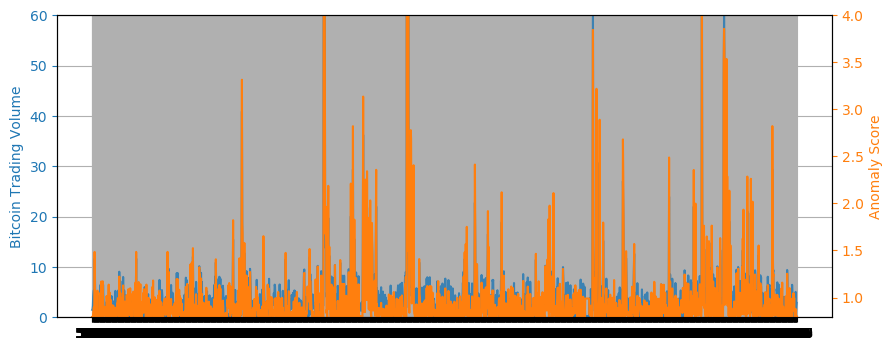

In [23]:
#Step 20: plot the anomaly scores on top of the volume chart, but don't plot too many points or things will die.

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
#start, end = 0, len(df1)  # this would be the entire dataset, and it will fail
start, end = 5500, 7500
df_subset = df[start:end]

ax1.plot(df_subset['value'], color='C0', alpha=0.8)
ax2.plot(df_subset['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Bitcoin Trading Volume', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax1.set_ylim(0, 60)
ax2.set_ylim(min(scores), 4)
fig.set_figwidth(10)

If we try to chart too many data elements, it will take forever to run, if it completes rendering at all. 2,000 data points takes over 5 minutes, which makes no sense to me.

Note that the anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point as well as in some places where our eyeballs are not as accurate.

Below we print and plot any data points with scores greater than 3 standard deviations (approx 99.9th percentile) from the mean score.

In [24]:
# Step 21: find all points where the anomaly score is greater than 3 standard deviations from the mean

score_mean = df['score'].mean()
score_std = df['score'].std()
score_cutoff = score_mean + 3*score_std

anomalies = df_subset[df_subset['score'] > score_cutoff]
anomalies

,timestamp,value,price,score
5925,2018-06-03 02:46:00,40.895463,831455.35705,3.314708
6157,2018-06-03 06:38:00,72.784258,838683.92024,4.080215
6158,2018-06-03 06:39:00,69.754692,840507.60105,4.031670
6159,2018-06-03 06:40:00,78.789453,843748.90896,4.165863
6160,2018-06-03 06:41:00,75.351085,845907.40337,4.117729
6240,2018-06-03 08:01:00,29.381822,843266.06914,2.820833
6269,2018-06-03 08:30:00,36.232557,845459.38761,3.135725
6393,2018-06-03 10:34:00,87.628643,844580.22899,4.279047
6395,2018-06-03 10:36:00,44.382115,844076.00392,3.432091
6396,2018-06-03 10:37:00,36.438271,843833.08912,3.143494


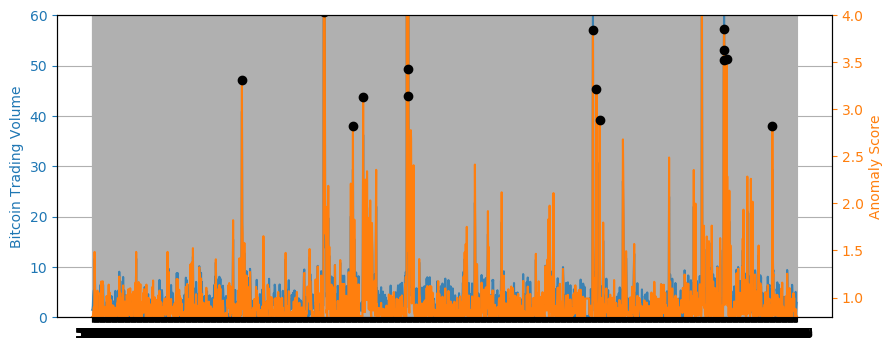

In [25]:
# Step 22: add the outlier anomalies to the plot
ax2.plot(anomalies.index, anomalies.score, 'ko')
fig

With the current hyperparameter choices we see that the three-standard-deviation threshold, while able to capture the known anomalies as well as the ones apparent in the ridership plot, is rather sensitive to fine-grained peruturbations and anomalous behavior. Adding trees to the SageMaker RCF model could smooth out the results as well as using a larger data set.

## Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [26]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2018-09-29-23-35-30-556


# Epilogue

---

We used Amazon SageMaker Random Cut Forest to detect anomalous datapoints in a taxi ridership dataset. In these data the anomalies occurred when ridership was uncharacteristically high or low. However, the RCF algorithm is also capable of detecting when, for example, data breaks periodicity or uncharacteristically changes global behavior.

Depending on the kind of data you have there are several ways to improve algorithm performance. One method, for example, is to use an appropriate training set. If you know that a particular set of data is characteristic of "normal" behavior then training on said set of data will more accurately characterize "abnormal" data.

Another improvement is make use of a windowing technique called "shingling". This is especially useful when working with periodic data with known period, such as the NYC taxi dataset used above. The idea is to treat a period of $P$ datapoints as a single datapoint of feature length $P$ and then run the RCF algorithm on these feature vectors. That is, if our original data consists of points $x_1, x_2, \ldots, x_N \in \mathbb{R}$ then we perform the transformation,

```
data = [[x_1],            shingled_data = [[x_1, x_2, ..., x_{P}],
        [x_2],    --->                     [x_2, x_3, ..., x_{P+1}],
        ...                                ...
        [x_N]]                             [x_{N-P}, ..., x_{N}]]

```

In [50]:
#figuring out how to filter a numpy array based on conditionals
snip = df[(df['timestamp'] > '2017-07-04 08:02:00') & ('2017-07-04 08:07:00' > df['timestamp'])]
print(snip)

            timestamp     value         price     score
2 2017-07-04 08:03:00  5.527494  296063.83615  0.708205
3 2017-07-04 08:04:00  8.414064  296125.66780  0.724346
4 2017-07-04 08:05:00  3.993010  296340.78573  0.721980
5 2017-07-04 08:06:00  4.112958  296216.13506  0.720866


In [112]:
import numpy as np

def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data-shingle_size, shingle_size))
    
    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n:(n+shingle_size)]
    return shingled_data

# single data with shingle size=1440 (one day)
shingle_size = 1440
prefix_shingled = 'sagemaker/randomcutforest_shingled'
df_shingled = shingle(df.values[:,1], shingle_size)
print(df_shingled)

MemoryError: 

We create a new training job and and inference endpoint. (Note that we cannot re-use the endpoint created above because it was trained with one-dimensional data.)

In [19]:
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix_shingled),
                      output_path='s3://{}/{}/output'.format(bucket, prefix_shingled),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(df1_shingled))

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-09-23-01-04-36-549


...................
Docker entrypoint called with argument(s): train
[09/23/2018 01:07:41 INFO 140089343383360] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[09/23/2018 01:07:41 INFO 140089343383360] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batch_size': u'1000', u'feature_dim': u'48', u'num_samples_per_tree': u'512', u'num_trees': u'50'}
[09/23/2018 01:07:41 INFO 140089343383360] Final configuration: {u'_ftp_port': 8999, u'num_samples_per_tree': u'512', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': 

[09/23/2018 01:07:42 INFO 140089343383360] Master node: Serializing the RandomCutForest model
#metrics {"Metrics": {"serialize_model.time": {"count": 1, "max": 224.4410514831543, "sum": 224.4410514831543, "min": 224.4410514831543}}, "EndTime": 1537664862.879302, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "RandomCutForest"}, "StartTime": 1537664862.654815}

[09/23/2018 01:07:42 INFO 140089343383360] Test data is not provided.
[I 18-09-23 01:07:42] >>> shutting down FTP server (0 active fds) <<<
[09/23/2018 01:07:42 INFO 140087840978688] >>> shutting down FTP server (0 active fds) <<<
#metrics {"Metrics": {"totaltime": {"count": 1, "max": 1382.9710483551025, "sum": 1382.9710483551025, "min": 1382.9710483551025}, "setuptime": {"count": 1, "max": 186.2039566040039, "sum": 186.2039566040039, "min": 186.2039566040039}}, "EndTime": 1537664862.986989, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "RandomCutForest"}, "StartTime": 1537664862.8

In [20]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'appliation/json'
rcf_inference.deserializer = json_deserializer

INFO:sagemaker:Creating model with name: randomcutforest-2018-09-23-01-16-26-722
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-09-23-01-04-36-549


----------------------------------------------------------------!

Using the above inference endpoint we compute the anomaly scores associated with the shingled data.

In [22]:
# Score the shingled datapoints
results = rcf_inference.predict(df1_shingled)
scores = np.array([datum['score'] for datum in results['scores']])

# compute the shingled score distribution and cutoff and determine anomalous scores
score_mean = scores.mean()
score_std = scores.std()
score_cutoff = score_mean + 3*score_std

anomalies = scores[scores > score_cutoff]
anomaly_indices = np.arange(len(scores))[scores > score_cutoff]

print(anomalies)

[1.45418524 1.46656971 1.46899792 1.47430758 1.49141953 1.49039036
 1.59260343 1.6962499  1.6718469  1.68406121 1.72868716 1.68030417
 1.63082737 1.64759024 1.66083292 1.65276261 1.71480767 1.71150822
 1.68430569 1.69679236 1.68878569 1.6255177  1.64611194 1.64336807
 1.61967915 1.58701812 1.57165953 1.62273285 1.56982387 1.58756687
 1.53624298 1.57770804 1.55094959 1.50758966 1.45760735 1.49787998
 1.47980195 1.46297147 1.48918049 1.48276982 1.45773467 1.49672629
 1.49484237 1.53084312 1.48827433 1.54543026 1.58353939 1.61961103
 1.60656566 1.60985029 1.60986329 1.59276841 1.64837936 1.6723408
 1.66814925 1.62214987 1.59216596 1.60750558 1.52170457 1.48919518
 1.47153961 1.49143836 1.49477577 1.54968782 1.53979592 1.51396926
 1.51645966 1.51176101 1.47594658 1.45929922 1.50540223 1.51667795
 1.51218639 1.57025847 1.56525761 1.57282579 1.57647523 1.6301422
 1.69663275 1.59348436 1.59695522 1.61422685 1.68647197 1.66394419
 1.68627142 1.76310116 1.79378283 1.74802567 1.75442458 1.791714

Finally, we plot the scores from the shingled data on top of the original dataset and mark the score lying above the anomaly score threshold.

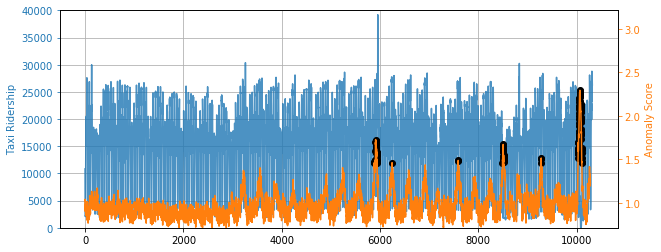

In [23]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(df1)
df1_subset = df1[start:end]

ax1.plot(df1['value'], color='C0', alpha=0.8)
ax2.plot(scores, color='C1')
ax2.scatter(anomaly_indices, anomalies, color='k')

ax1.grid(which='major', axis='both')
ax1.set_ylabel('Taxi Ridership', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')
ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')
ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

We see that with this particular shingle size, hyperparameter selection, and anomaly cutoff threshold that the shingled approach more clearly captures the major anomalous events: the spike at around t=6000 and the dips at around t=9000 and t=10000. In general, the number of trees, sample size, and anomaly score cutoff are all parameters that a data scientist may need experiment with in order to achieve desired results. The use of a labeled test dataset allows the used to obtain common accuracy metrics for anomaly detection algorithms. For more information about Amazon SageMaker Random Cut Forest see the [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

In [24]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2018-09-23-01-04-36-549
